In [54]:
import ot
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
from sklearn.base import clone
import seaborn as sns
from tqdm import tqdm, tqdm_notebook
from utils import construct_confidence_interval, plot_pies

import sklearn
from sklearn.preprocessing import LabelBinarizer, LabelEncoder, StandardScaler
from sklearn.model_selection import ShuffleSplit
from collections import Counter
from utils import balanced_error_rate, disparate_impact, likelihood_ratio, pretty_confusion_matrix
import pickle as pl

In [55]:
nrows = None

In [56]:
random_seed = 4717#np.random.randint(0, 13239)
print(random_seed)

4717


In [57]:
numerical_features_index = [1, 4, 7, 10, 12, 15, 17]

In [58]:
data_train = pd.read_csv('../datasets/German Credit Score/german.data', header=None, sep='\s+')
data_train.drop_duplicates(inplace=True)

y_data = data_train.loc[:, data_train.columns[-1]]
protected_attribute = data_train.loc[:, data_train.columns[8]]

data_train.drop(data_train.columns.difference(numerical_features_index), axis=1, inplace=True)
data_train = data_train.astype(np.float64)

protected_attribute = protected_attribute.apply(lambda x: x.strip())
protected_attribute = protected_attribute.apply(lambda x: 0 if x == 'A92' or x == 'A95' else 1)

In [59]:
scaler = StandardScaler()
data = scaler.fit_transform(data_train)

shuffle_splitter = ShuffleSplit(n_splits=1, test_size=0.5, random_state=random_seed)

y_data = y_data.apply(lambda x: 0 if x == 2 else 1)

<Figure size 1440x1440 with 0 Axes>

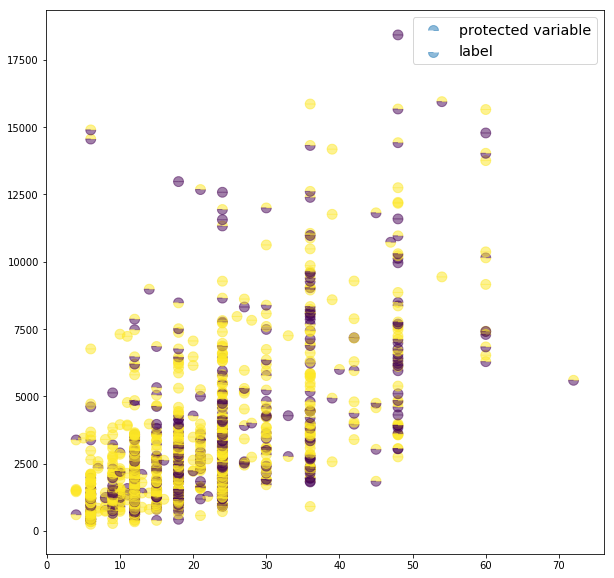

In [60]:
f, ax = plot_pies(data_train.values, protected_attribute, y_data, alpha=0.5)

In [61]:
#f.savefig('/home/grapefroot/Dropbox/Apps/Overleaf/writeup/img/german_credit_scoring.pgf', frameon=True, transparent=True, bbox_inches='tight')

In [62]:
for train_index, test_index in shuffle_splitter.split(data):
    data_train, data_test = data[train_index], data[test_index]
    y_train, y_test = y_data[train_index], y_data[test_index]
    protected_train, protected_test = protected_attribute[train_index], protected_attribute[test_index]
    break

In [63]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from collections import Counter
from sklearn.model_selection import GridSearchCV

In [64]:
# clf_base = RandomForestClassifier(class_weight={0:5, 1:1})#random_state=random_seed)

# param_grid = {
#     'n_estimators': [10, 50, 100, 200, 500, 1000],
#     'max_depth': [None, 2, 3, 4, 5, 6],
#     'min_samples_split': [2, 3, 4, 5]
# }
# CLF_NAME = 'Random Forest'

In [65]:
clf_base = GradientBoostingClassifier()

param_grid = {
    'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2],
    'n_estimators': [100, 200, 500, 1000],
    'min_samples_split': [2, 3, 4, 5],
    'max_depth':[None, 2, 3, 4, 5, 6]
}
CLF_NAME = 'Gradient Boosting'

In [66]:
# clf_base = LogisticRegression()
# param_grid = {
#     'penalty': ['l1', 'l2'],
#     'C':[0.01, 0.05, 0.1, 0.2, 0.5, 1],
# }

# CLF_NAME = 'Logistic Regression'

In [67]:
clf = GridSearchCV(clf_base, param_grid, n_jobs=-1, verbose=1, refit=True)
clf.fit(data_train, y_train)

Fitting 3 folds for each of 480 candidates, totalling 1440 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   26.2s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   41.6s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 1440 out of 1440 | elapsed:  1.1min finished


GridSearchCV(cv=None, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=None,
              subsample=1.0, verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'learning_rate': [0.01, 0.02, 0.05, 0.1, 0.2], 'n_estimators': [100, 200, 500, 1000], 'min_samples_split': [2, 3, 4, 5], 'max_depth': [None, 2, 3, 4, 5, 6]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=1)

In [68]:
clf_predictions = clf.predict(data_test)

In [69]:
accuracy_before = accuracy_score(y_test, clf_predictions)
di_before = disparate_impact(clf_predictions, protected_test)
print('Initial accuracy of classification: {}'.format(accuracy_before))
print('Initial f1 of classification: {}'.format(f1_score(y_test, clf_predictions)))
print('Initial DI: {}'.format(di_before))

Initial accuracy of classification: 0.704
Initial f1 of classification: 0.8225419664268585
Initial DI: 1.0086303939962475


In [70]:
negative_label = 0
positive_label = 1

In [71]:
male_entries_index = protected_train[protected_train == positive_label]
female_entries_index = protected_train[protected_train == negative_label]

male_entries_test_index = protected_test[protected_test == positive_label]
female_entries_test_index = protected_test[protected_test == negative_label]

n0 = data_train[protected_train == positive_label].shape[0]
n1 = data_train[protected_train == negative_label].shape[0]
n0_test = data_test[protected_test == positive_label].shape[0]
n1_test = data_test[protected_test == negative_label].shape[0]

emperical_histogram_male = np.ones_like(male_entries_index) / n0
emperical_histogram_female = np.ones_like(female_entries_index) / n1

emperical_histogram_male_test = np.ones_like(male_entries_test_index) / n0_test
emperical_histogram_female_test = np.ones_like(female_entries_test_index) / n1_test

In [72]:
C = ot.dist(data_test[protected_test == positive_label], data_test[protected_test == negative_label])

In [73]:
C /= C.max()

In [74]:
%%time
coupling = ot.emd(emperical_histogram_male_test, emperical_histogram_female_test, C, numItermax=1000000000)

CPU times: user 13.3 ms, sys: 185 µs, total: 13.5 ms
Wall time: 13.3 ms


In [75]:
def f(G):
    return 0.5 * np.sum(G**2)

def df(G):
    return G

In [76]:
#coupling1 = ot.optim.gcg(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg1=1e-3, reg2=1e-1, f=f, df=df, verbose=True)
%time
#coupling1 = ot.stochastic.solve_semi_dual_entropic(emperical_histogram_male_test, emperical_histogram_female_test, C, reg=1, method='SAG', numItermax=100000, log=True)[0]
coupling1 = ot.bregman.sinkhorn(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.002, stopThr=1e-9, verbose=True)

CPU times: user 2 µs, sys: 4 µs, total: 6 µs
Wall time: 11.4 µs
It.  |Err         
-------------------
    0|6.344030e-03|
   10|2.987576e-03|
   20|1.523692e-03|
   30|2.875062e-04|
   40|6.855113e-05|
   50|2.712422e-05|
   60|1.213604e-05|
   70|4.118559e-06|
   80|1.686463e-06|
   90|8.259748e-07|
  100|4.613795e-07|
  110|2.795240e-07|
  120|1.791461e-07|
  130|1.203758e-07|
  140|8.458841e-08|
  150|6.210494e-08|
  160|4.756446e-08|
  170|3.786963e-08|
  180|3.117364e-08|
  190|2.634712e-08|
It.  |Err         
-------------------
  200|2.268567e-08|
  210|1.974490e-08|
  220|1.724549e-08|
  230|1.501742e-08|
  240|1.296587e-08|
  250|1.104871e-08|
  260|9.259329e-09|
  270|7.612045e-09|
  280|6.129255e-09|
  290|4.831036e-09|
  300|3.728259e-09|
  310|2.819766e-09|
  320|2.093117e-09|
  330|1.527653e-09|
  340|1.098393e-09|
  350|7.795744e-10|


In [77]:
coupling2 = ot.bregman.partial_transport(emperical_histogram_male_test, emperical_histogram_female_test, C / C.max(), reg=0.002, verbose=0, stopThr=1e-9, numItermax=100000, m=1)

In [78]:
y_first = y_test[protected_test == positive_label]
y_second = y_test[protected_test == negative_label]
print('class 0 size {}'.format(y_first.shape))
print('class 1 size {}'.format(y_second.shape))

class 0 size (336,)
class 1 size (164,)


In [79]:
from mapper import full_repair, partial_repair, random_repair_original
from utils import balanced_error_rate, disparate_impact, likelihood_ratio

In [80]:
from utils import evaluate_metrics, evaluate_repair, plot_metrics

In [81]:
from functools import partial

In [82]:
predicted_fairness_dict = {
    'DI': disparate_impact,
    'CI': partial(construct_confidence_interval, level=0.95),
}

accuracy_metrics_dict = {
    'Accuracy': accuracy_score,
}

In [83]:
from collections import defaultdict
from tqdm import tqdm

In [84]:
partial_repair_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling, y0, y1)
random_repair_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling, y0, y1, theta=rv)
partial_repair_reg_func = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling1, y0, y1)
random_repair_reg_func = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling1, y0, y1, theta=rv)

partial_repair_reg_func_pt = lambda rv, c0, c1, y0, y1: partial_repair(rv, c0 ,c1, coupling2, y0, y1)
random_repair_reg_func_pt = lambda rv, c0, c1, y0, y1: random_repair_original(c0, c1, coupling2, y0, y1, theta=rv)

In [85]:
protected_test_new = np.concatenate((np.ones(y_first.shape[0]), np.zeros(y_second.shape[0])))

In [86]:
evaluation_1 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, partial_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='full ot')

100%|██████████| 100/100 [00:01<00:00, 59.16it/s]


In [87]:
evaluation_2 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, random_repair_func, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=10, name='random repair full ot')#

100%|██████████| 100/100 [00:10<00:00,  9.40it/s]


In [88]:
evaluation_3 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, partial_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, name='entropically regularized ot')

100%|██████████| 100/100 [00:01<00:00, 93.79it/s]


In [89]:
evaluation_4 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, random_repair_reg_func, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=10, name='random repair regularized ot')

100%|██████████| 100/100 [00:10<00:00,  9.53it/s]


In [90]:
evaluation_5 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, partial_repair_reg_func_pt, clf, predicted_fairness_dict, accuracy_metrics_dict, name='partial repair regularized ot')

100%|██████████| 100/100 [00:01<00:00, 94.41it/s]


In [91]:
evaluation_6 = evaluate_repair(data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second, protected_test_new, random_repair_reg_func_pt, clf, predicted_fairness_dict, accuracy_metrics_dict, n_trials=1, name='random repair partial regularized ot')

100%|██████████| 100/100 [00:01<00:00, 92.94it/s]


In [92]:
XX, yy = partial_repair_reg_func_pt(1, data_test[protected_test == positive_label], data_test[protected_test == negative_label], y_first, y_second)
disparate_impact(clf.predict(XX), protected_test_new)

0.9995565410199556

In [98]:
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_1['Accuracy'][-1], evaluation_1['DI'][-1]))
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_3['Accuracy'][-1], evaluation_3['DI'][-1]))
print('{} & {:.3f} & {:.3f} & {:.3f} & {:.3f}'.format(CLF_NAME, accuracy_before, di_before, evaluation_5['Accuracy'][-1], evaluation_5['DI'][-1]))

Gradient Boosting & 0.704 & 1.009 & 0.698 & 1.006
Gradient Boosting & 0.704 & 1.009 & 0.700 & 1.000
Gradient Boosting & 0.704 & 1.009 & 0.700 & 1.000


(<Figure size 720x3600 with 5 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1cf89bc278>,
       dtype=object))

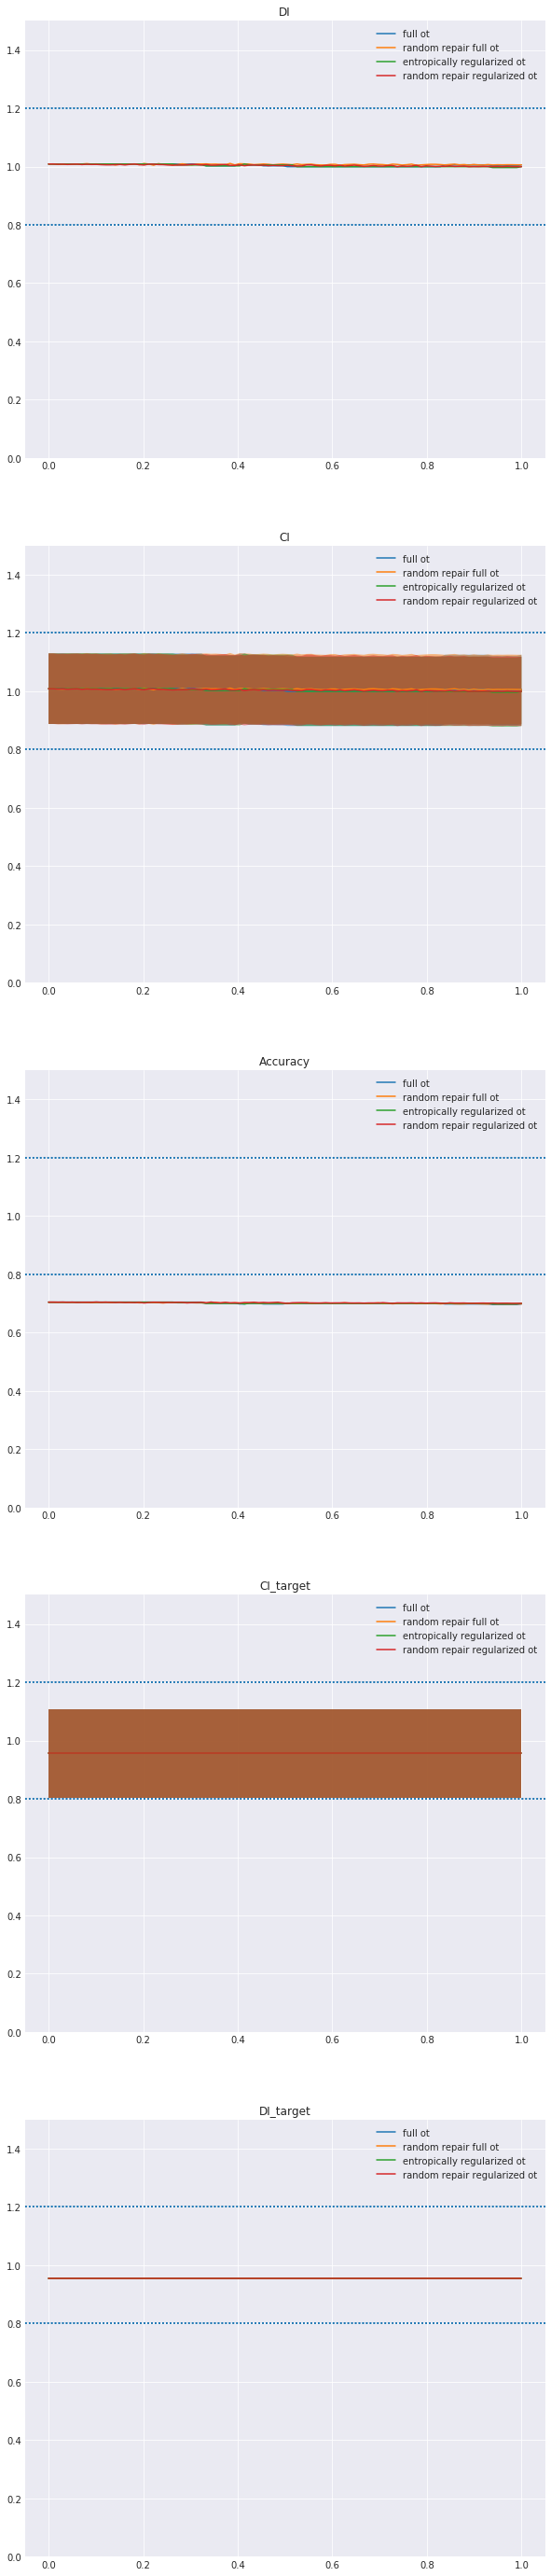

In [94]:
plot_metrics([evaluation_1, evaluation_2, evaluation_3, evaluation_4])

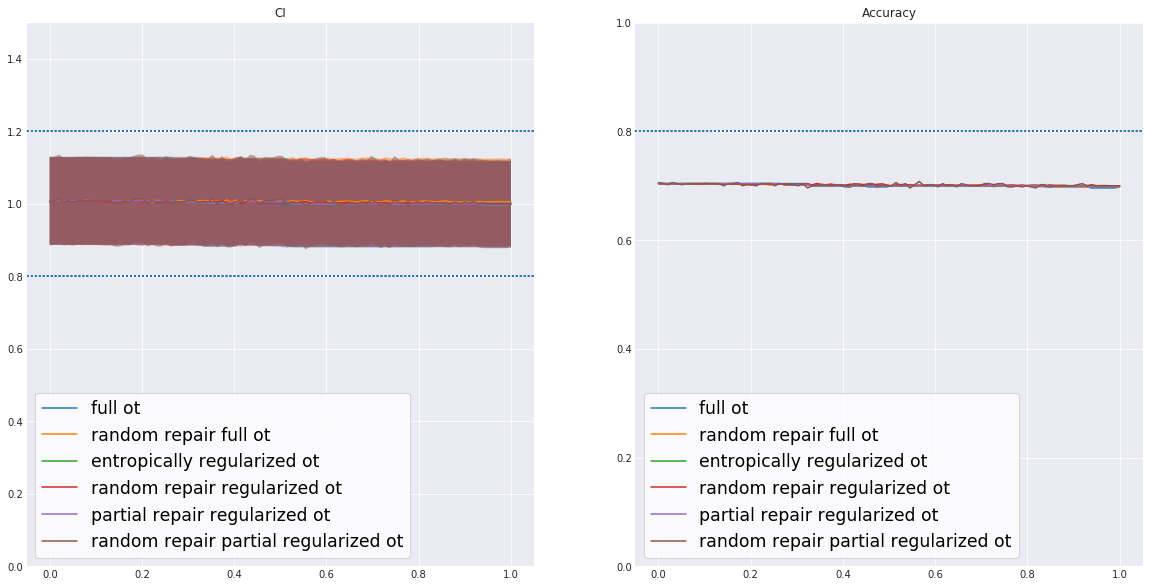

In [95]:
fig, aaaa = plot_metrics([evaluation_1, evaluation_2, evaluation_3, evaluation_4, evaluation_5, evaluation_6], what_to_plot=['CI', 'Accuracy'], subplot_shape=(1, 2), subplot_size=(20, 10))
aaaa[1].set_ylim(0, 1)
aaaa[0].legend(fontsize='xx-large', loc='best')
aaaa[1].legend(fontsize='xx-large', loc='best')

In [96]:
fig.savefig('/home/grapefroot/Dropbox/Apps/Overleaf/writeup/img/german_credit_scoring_tradeoff_gb.pgf', frameon=True, bbox_inches='tight')

In [97]:
with open('/home/grapefroot/Dropbox/Apps/Overleaf/writeup/img/german_credit_scoring_tradeoff_gb.pickle', mode='wb') as file:
    pl.dump(fig, file)

How to understand how many points are translated? Since we have that $1^\top \gamma 1 = m$, that means that 